### Assignment 3
#### Steven H. Yang, Minerva University

## Assignment instructions:

### Yosemite Village yearly weather
Temperature is cyclical, not only on a 24 hour basis but also on a yearly basis. Convert the dataset into a richer format whereby the day of the year is also captured. For example the time “20150212 1605”, can be converted into (43, 965) because the 12th of February is the 43rd day of the year, and 16:05 is the 965th minute of the day.

This data covers 6 years, so split the data into a training set of the first 5 years, and a testing set of the 6th year.


In [11]:
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import rbf_kernel

## `Data Cleaning:`

First, I separate the data into training and testing data sets. Training dataset is the first five years and the testing dataset is the last one year of the dataset.
I used `glob` module to select every file in the folder and defineed the training and testing dataset. 

I also imported the necessary columns so that the algorithm can run faster. For the next step, I used the defined functions below to convert date and time in a format.

In [12]:
# Create paths to training dataset
dataset = glob('yosemite-temperatures/yosemite_village/*')

# Get the training data for the first five years, excluding the last one.
for i in range(len(dataset)-1):
    
    if i==0:
        training_data = pd.read_csv(dataset[i], header = None, names=['WBANNO', 'UTC_DATE', 'UTC_TIME', 'LST_DATE', 'LST_TIME',
        'CRX_VN', 'LONGITUDE', 'LATITUDE', 'AIR_TEMPERATURE', 'PRECIPITATION', 'SOLAR_RADIATION', 'SR_FLAG', 'SURFACE_TEMPERATURE',
        'ST_TYPE', 'ST_FLAG', 'RELATIVE_HUMIDITY', 'RH_FLAG', 'SOIL_MOISTURE_5', 'SOIL_TEMPERATURE_5', 'WETNESS', 'WET_FLAG',
        'WIND_1_5', 'WIND_FLAG'], usecols = ['UTC_DATE', 'UTC_TIME', 'AIR_TEMPERATURE'], delimiter='\s+')
        
    # Repeat the above procedure for the following years
    else:
        present = pd.read_csv(dataset[i], header = None, names=['WBANNO', 'UTC_DATE', 'UTC_TIME', 'LST_DATE', 'LST_TIME',
        'CRX_VN', 'LONGITUDE', 'LATITUDE', 'AIR_TEMPERATURE', 'PRECIPITATION', 'SOLAR_RADIATION', 'SR_FLAG', 'SURFACE_TEMPERATURE',
        'ST_TYPE', 'ST_FLAG', 'RELATIVE_HUMIDITY', 'RH_FLAG', 'SOIL_MOISTURE_5', 'SOIL_TEMPERATURE_5', 'WETNESS', 'WET_FLAG',
        'WIND_1_5', 'WIND_FLAG'], usecols = ['UTC_DATE', 'UTC_TIME', 'AIR_TEMPERATURE'], delimiter='\s+')
        training_data = pd.concat([training_data, present], axis = 0)
        
# Set the 6th year as a testing data
testing_data = pd.read_csv(dataset[5], header = None, names=['WBANNO', 'UTC_DATE', 'UTC_TIME', 'LST_DATE', 'LST_TIME',
        'CRX_VN', 'LONGITUDE', 'LATITUDE', 'AIR_TEMPERATURE', 'PRECIPITATION', 'SOLAR_RADIATION', 'SR_FLAG', 'SURFACE_TEMPERATURE',
        'ST_TYPE', 'ST_FLAG', 'RELATIVE_HUMIDITY', 'RH_FLAG', 'SOIL_MOISTURE_5', 'SOIL_TEMPERATURE_5', 'WETNESS', 'WET_FLAG',
        'WIND_1_5', 'WIND_FLAG'], usecols = ['UTC_DATE', 'UTC_TIME', 'AIR_TEMPERATURE'], delimiter='\s+')

# Convert the date column to applicable format for code use
def date_convert(x):
    '''
    This function converts the date in months and day to the day of the year.
    INPUT
    -----
    x, int: date in numbers
    OUTPUT
    ------
    converted, int: the converted date
    '''
    # Change the variable type to string
    x = str(x)
    
    # Reference for the months
    month_list = {"01": [0, 31], "02": [31, 28], "03": [59, 31], "04": [90, 30], "05": [120, 31], "06": [151, 30], "07": [181, 31], "08": [212,31], "09": [243, 30], "10": [273, 31], "11": [304, 30], "12": [334, 31]}
    
    # Seperate each day, month, and year
    day = x[6:8]
    month = x[4:6]
    year = x[:4]
    converted = int(day) + month_list[month][0]
    # Return the converted value
    return converted


def time_convert(x):
    '''
    This function converts the time into a format
    INPUT
    -----
    x, int: time in numbers
    OUTPUT
    ------
    converted, int: the converted time
    '''
    # Get the hour side
    hour = int(x/100)
    
    # Get the minutes side
    minute = np.mod(x, 100)
    
    # Converted result
    converted = hour*60 + minute
    
    # Return converted
    return converted


# Create a new column to store  year
training_data["UTC_YEAR"] = training_data["UTC_DATE"].apply(lambda x: int(str(x)[:4]))
testing_data["UTC_YEAR"] = testing_data["UTC_DATE"].apply(lambda x: int(str(x)[:4]))

# Update "UTC_DATE" column with convert
training_data["UTC_DATE"] = training_data["UTC_DATE"].apply(date_convert)
testing_data["UTC_DATE"] = testing_data["UTC_DATE"].apply(date_convert)

# Update "UTC_TIME" column with convert
training_data["UTC_TIME"] = training_data["UTC_TIME"].apply(time_convert)
testing_data["UTC_TIME"] = testing_data["UTC_TIME"].apply(time_convert)


# Eliminate outliers so that the model can fit better
training_data = training_data[training_data['AIR_TEMPERATURE'] >= -50]
testing_data = testing_data.loc[testing_data['AIR_TEMPERATURE'] >= -50]

# Reset the indexe
training_data.reset_index(drop=True, inplace=True)
testing_data.reset_index(drop=True, inplace=True)

# To see the result of data cleaning
training_data, testing_data

(        UTC_DATE  UTC_TIME  AIR_TEMPERATURE  UTC_YEAR
 0              1         5             -6.4      2011
 1              1        10             -6.5      2011
 2              1        15             -6.5      2011
 3              1        20             -6.5      2011
 4              1        25             -6.7      2011
 ...          ...       ...              ...       ...
 525784       365      1420             -1.4      2015
 525785       365      1425             -1.6      2015
 525786       365      1430             -1.4      2015
 525787       365      1435             -1.6      2015
 525788         1         0             -1.6      2016
 
 [525789 rows x 4 columns],
         UTC_DATE  UTC_TIME  AIR_TEMPERATURE  UTC_YEAR
 0              1         5             -2.5      2013
 1              1        10             -2.7      2013
 2              1        15             -3.1      2013
 3              1        20             -3.2      2013
 4              1        25        

## `Model Selection`

To best reflect the expected behavior in temperatures with time, there was the need to identify the contributing properties of each quantity and model the kernel picks in a manner reflecting this. 

Before moving on the model selection, followings are expected observations or more likely to happen as the dataset is the real-world dataset.
Over the day:
1. Each year, overall temperature MIGHT increased due to the global warming.
2. The temperature will be high during the summer but low during the winter. During the fall and spring, they might seem similar but lower in fall.

Over the time:
1. Each day will show different trends of temperature based on its season.
2. I expect the negative parabola as the temperature will low in the morning, increase at noon, and drop again in the evening.

Based on this real-world settings, expoential kernel should be the best choice; however, as this report misses the exponential kernel, I use RBF kernel. Since I am using an RBF kernel to replace the exponential kernel, a small $\sigma$ value will allow the model to explore more about data.

As for an experiment, I also bring the linear parameter model with the linear kernel. This is a good choice for year to year observation as there is a global warming over the years. To mention, I use a large $\sigma$ value here to respond so that the reflection is not making huge jumps.

If I sum these two kernels, that would show both day and year predictions.

To reflect across the day change, I also pick a large $\sigma$ value to respond increase of temperature at noon and drop by evening.

In [22]:
def rbf_convert(models):
    # create the centers of data
    date_centers = np.asarray([i for i in np.linspace(1, 365, 200)]).reshape(-1, 1)
    time_centers = np.asarray([i for i in np.linspace(0, 1440, 200)]).reshape(-1, 1)
    
    # Large sigma refers the year changes
    large_sigma = 1000
    year_kernel = rbf_kernel(models[["UTC_DATE"]], date_centers, gamma = 1.0/large_sigma)

    # Small sigma refers the seasonal changes. As there are 4 seasons, I set it by 0.25
    small_sigma = 0.25
    seasonal_kernel = rbf_kernel(models[["UTC_DATE"]], date_centers, gamma = 1.0/small_sigma)

    # Daily kernel is the sum of both year and seasonal kernel
    daily_kernel = year_kernel + seasonal_kernel
    daily_kernel = pd.DataFrame(daily_kernel)

    # This is a big sigma value to respond to the sudden change during the day but still smaller sigma because it's not long-term
    med_sigma = 500
    time_kernel = rbf_kernel(models[["UTC_TIME"]], time_centers, gamma = 1.0/med_sigma)
    time_kernel = pd.DataFrame(time_kernel)
    
    return [daily_kernel, time_kernel]

2. Using this new representation, build a linear parameter model that captures both seasonal variations and daily variations.

In [23]:
# Get Training kernel by applying rbf_convert to the training data
training_kernel = pd.concat(rbf_convert(training_data), axis = 1)
training_kernel.columns = range(training_kernel.shape[1])

# Create a linear model
lin_regr = linear_model.LinearRegression()
lin_regr.fit(training_kernel, training_data["AIR_TEMPERATURE"])

# Get the R2 score of the training data
print("R2 score on training data = ", lin_regr.score(training_kernel, training_data["AIR_TEMPERATURE"]))

R2 score on training data =  0.6592331325944867


Evaluation of the R2 score:
The above R2 score shows that the linear regression model shows the moderate trend of the data. This is not bad but still not good enough.

3. Create two plots, one showing the time-of-day contribution, and one showing the time-of-year contribution.

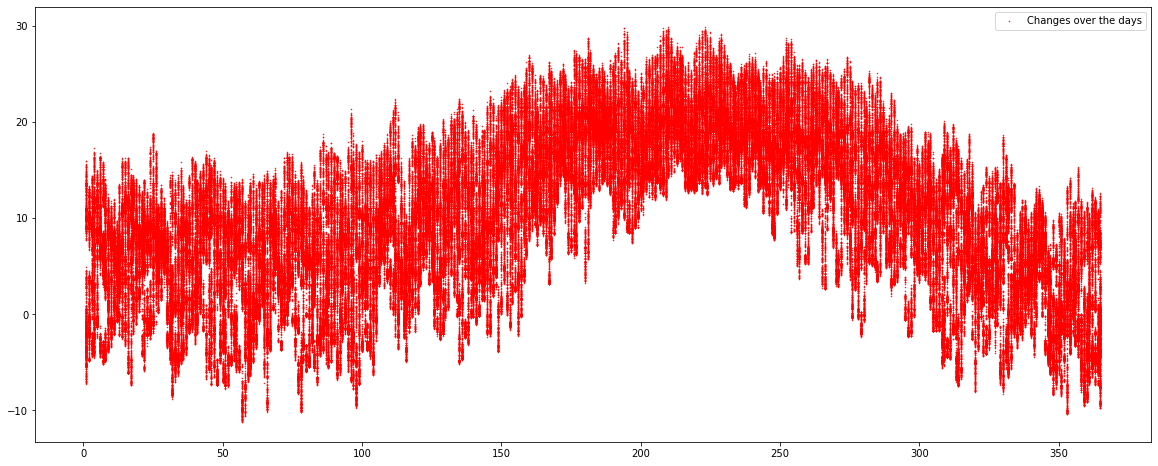

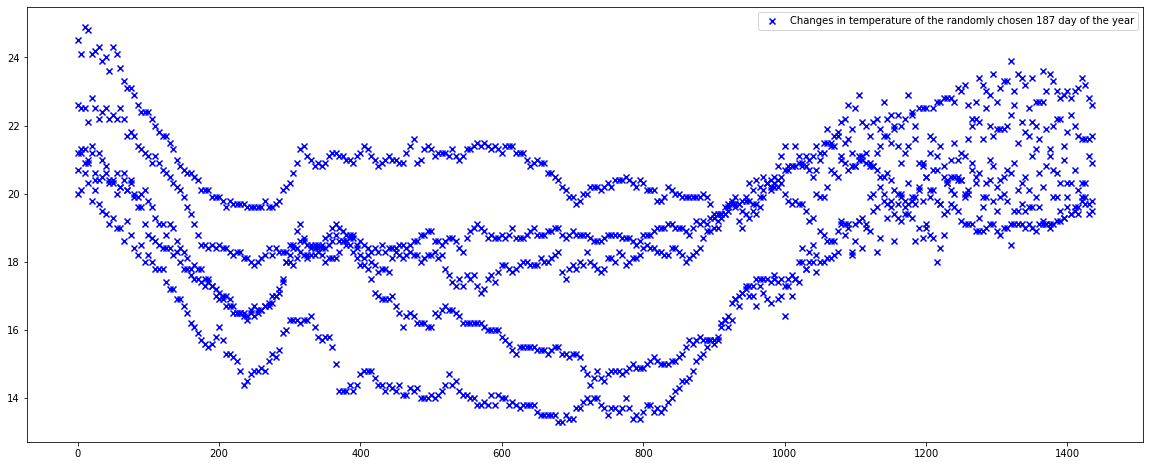

In [37]:
# Following scatter plot will show trend of the days over a year.
plt.figure(figsize=(20,8))
plt.scatter(training_data["UTC_DATE"], training_data["AIR_TEMPERATURE"], label='Changes over the days', color='red', marker= "o", s=0.25)
plt.legend(loc='best')
plt.show()

# Randomly pick a day in the year to show time-of-day contribution
# Choose a random day from the dataset to show a changes in a day.
time_condition = np.random.choice(training_data['UTC_DATE'])

# Following scatter plot will show trend of the change in a random day.
plt.figure(figsize=(20,8))
plt.scatter(training_data[training_data['UTC_DATE'] == time_condition]["UTC_TIME"], training_data[training_data['UTC_DATE'] == time_condition]["AIR_TEMPERATURE"], label=f'Changes in temperature of the randomly chosen {time_condition-1} day of the year', color='blue', marker = "x")
plt.legend(loc='best')
plt.show()

The second graph is an interesting observation as I was expecting a negative parabola. For some reason, the temperature drops down at noon and increases in the evening. I think this need a further investigation what is happening on Yosemite exceptionally.

4. (Optional) Make a 3D plot showing temperature as a function of (day, time). Make sure to label your axes!

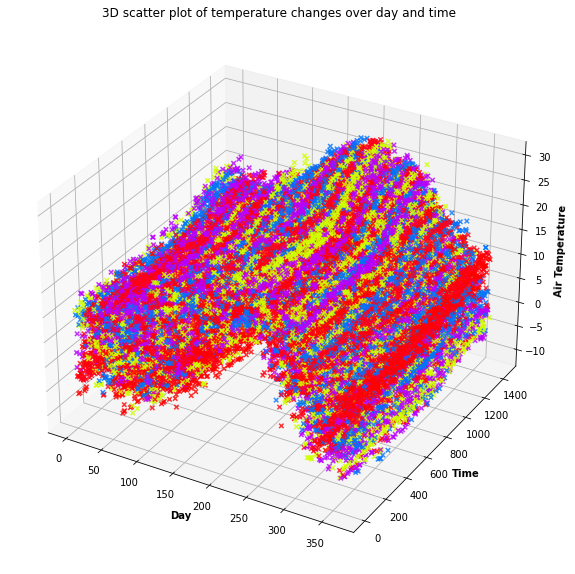

In [50]:
# Create a 3D figure
fig = plt.figure(figsize = (30, 10))
threeD = plt.axes(projection = "3d")

default_cmap = plt.get_cmap('hsv')
   
# X, Y gridlines
threeD.grid(visible = True, color ='blue', linestyle ='-.-', linewidth = 0.5, alpha = 0.2)
 
# Get 10% of data for a sample
plotted_data = training_data.sample(frac=0.10, replace=False)

plot_3d = threeD.scatter3D(plotted_data["UTC_DATE"], plotted_data["UTC_TIME"], 
                    plotted_data["AIR_TEMPERATURE"], alpha = 0.8,
                    cmap = default_cmap, c = plotted_data["UTC_YEAR"], marker = 'x')

# Labeling
plt.title("3D scatter plot of temperature changes over day and time")
threeD.set_xlabel('Day', fontweight ='bold')
threeD.set_ylabel('Time', fontweight ='bold')
threeD.set_zlabel('Air Temperature', fontweight ='bold')
plt.show()

5. Using R², quantify how your model performs on the testing data if you:
    1. Train with just the daily component of the model
    2. Train with just the yearly component of the model
    3. Train with the full model.

In [53]:
# To get the number of kernels
len(rbf_convert(training_data))

2

In [55]:
# Yearly variation kernel
first_trained_kernel = rbf_convert(training_data)[0]

# Create a model to apply the RBF kernels
model1 = linear_model.LinearRegression()
model1.fit(first_trained_kernel, training_data["AIR_TEMPERATURE"])
# Get the R2 score of training data
print("R2 score on training data = ", model1.score(first_trained_kernel, training_data["AIR_TEMPERATURE"]))

# Yearly variation kernel
first_test_kernel = rbf_convert(testing_data)[0]

# Predict
prediction1 = model1.predict(first_test_kernel)

# Get the R2 score of testing data
print("R2 score on testing data = ", r2_score(testing_data["AIR_TEMPERATURE"], prediction1))


Score on training data =  0.6158852783910296
Score on testing data =  0.4712519987912225


Evaluation: This is a moderate R2 score that tells us there's a moderate yearly trend.

In [56]:
# Yearly variation kernel
second_trained_kernel = rbf_convert(training_data)[1]

# Create a model to apply the RBF kernels
model2 = linear_model.LinearRegression()
model2.fit(second_trained_kernel, training_data["AIR_TEMPERATURE"])
# Get the R2 score of training data
print("R2 score on training data = ", model2.score(second_trained_kernel, training_data["AIR_TEMPERATURE"]))

# Yearly variation kernel
second_test_kernel = rbf_convert(testing_data)[1]

# Predict
prediction2 = model2.predict(second_test_kernel)

# Get the R2 score of testing data
print("R2 score on testing data = ", r2_score(testing_data["AIR_TEMPERATURE"], prediction2))


Score on training data =  0.043149898239788764
Score on testing data =  0.050677262390156685


Evaluation: This is a very weak R2 score that tells us there's a very weak seasonal trend. However, I can still add up the kernels with above to make the prediction slightly better.

In [57]:
# Use both of the RBF kernels
final_training_kernel = pd.concat(rbf_convert(training_data), axis = 1)

final_training_kernel.columns = range(final_training_kernel.shape[1])

# Create a model
model3 = linear_model.LinearRegression()
model3.fit(final_training_kernel, training_data["AIR_TEMPERATURE"])

# Get the R2 score of training data
print("R2 score on training data = ", model3.score(final_training_kernel, training_data["AIR_TEMPERATURE"]))

# Use both of the RBF kernels
final_testing_kernel = pd.concat(rbf_convert(testing_data), axis = 1)

final_testing_kernel.columns = range(final_testing_kernel.shape[1])

# Predict
predictions3 = model3.predict(final_testing_kernel)

# Get the R2 score of testing data
print("R2 score on testing data = ", r2_score(testing_data["AIR_TEMPERATURE"], predictions3))


R2 score on training data =  0.6592331325944867
R2 score on testing data =  0.5226546784323577


Evaluation: One can see that R2 scores are now sum of the first and the second model. Throughout this experiment I observed using kernels separately and collect them together can predict a better trend of overall.

As a result, to interpret the R2 score, it is slightly better than the moderate result; however, possible rooms of improvements are following:

1. Need more dataset. I think having only six years to observe general year trend is not good.
2. Get a global warming temperature increase rate and adjust the years based on that to observe a more generous trend.